# Truss Simulation

In [1]:
#A Simple Truss Structure Finite Element Analysis Programme
#A Dickinson, 18/02/2022

In [2]:
import numpy as np
import matplotlib.pyplot as pl
import matplotlib.axes as ax
# replace inline with qt to have plots appearing in a separate window
%matplotlib inline
np.set_printoptions(precision=1)
#np.set_printoptions(suppress=True)

In [3]:
#Define Node Locations and Element Connectivity:
#define nodal coordinates in a 2 x n array,
nodes = np.array([[0.0, 0.0],
                  [1.0, 0.0],
                  [2.0, 0.0],
                  [0.5, 0.8],
                  [1.5, 1.0],
                  [3.0, 0.0], #
                  [2.5, 0.8]])#
#and define element connectivity in a 2 x m array of corresponding integers, numbered from 1
elemcon = np.array([[1, 2],
                    [2, 3],
                    [1, 4],
                    [2, 4],
                    [2, 5],
                    [3, 5],
                    [4, 5],
                    [3, 6], #
                    [3, 7], #
                    [5, 7], #
                    [6, 7]])#

#and define element data in a 2 x m array corresponding to elemcon. 
#Column 1 is cross section area,
#Column 2 is Young's modulus
ESteel=207e9
ARod1=np.pi*20e-3**2
ARod2=np.pi*25e-3**2
elemdata = np.array([[ARod1, ESteel, 0],
                    [ARod1, ESteel, 0],
                    [ARod2, ESteel, 0],
                    [ARod2, ESteel, 0],
                    [ARod2, ESteel, 0],
                    [ARod2, ESteel, 0],
                    [ARod2, ESteel, 0],
                    [ARod1, ESteel, 0], #
                    [ARod2, ESteel, 0], #
                    [ARod2, ESteel, 0], #
                    [ARod2, ESteel, 0]])#
#Calculate a Column 3 of element lengths:
elemdata[:,2]=((nodes[elemcon[:,0]-1,0]-nodes[elemcon[:,1]-1,0])**2+(nodes[elemcon[:,0]-1,1]-nodes[elemcon[:,1]-1,1])**2)**0.5

#Define Boundary Conditions. Set Nodes with zero DoFs:
XBCs = np.array([1, 6])#XBCs = np.array([1, 0])
YBCs = np.array([1, 6])

#Define Loads.
Loads = np.array([[0.0, 0.0],
                  [0.0, -10000],
                  [0.0, -10000],
                  [0.0, 0.0],
                  [0.0, 0.0],
                  [0.0, 0.0], #
                  [0.0, 0.0]])#

In [4]:
def plotting(nodes,elemcon,nodenums=1,elemnums=1,loads=0,deformations=0,dscale=0):
    """
    Plot the finite element model geometry using nodal coordinates in a 2 x n array,
    and element connectivity in a 2 x m array of integers. Additional arguments are
    binary settings to control display of node or element numbers, defaulting on (=1).
    """
    #Plot the Mesh
    pl.figure()
    #Plot nodes
    pl.plot(nodes[:, 0], nodes[:, 1], 'ro', zorder=3)
    #Plot elements one by one. Note, node numbers have '-1' as numbered from 1, vs. python numbered from 0.
    pl.plot([nodes[elemcon[:,0]-1,0],nodes[elemcon[:,1]-1,0]],[nodes[elemcon[:,0]-1,1],nodes[elemcon[:,1]-1,1]],'k', zorder=2)
    pl.gca().set_aspect(1)
    pl.grid(1)
    
    if nodenums:
        #Plot node numbers
        for x in range(len(nodes)):
            nodename='n'+str(x+1)
            pl.text((nodes[x,0]),(nodes[x,1]-0.1),nodename,color='b')
    
    if elemnums:
        #Plot elem numbers
        for x in range(len(elemcon)):
            elemname='e'+str(x+1)
            pl.text((((nodes[elemcon[x,0]-1,0]+nodes[elemcon[x,1]-1,0])/2)),(((nodes[elemcon[x,0]-1,1]+nodes[elemcon[x,1]-1,1])/2)-0.1),elemname,color='k')

    if loads:
        #Plot load symbols:
        for x in range(len(Loads)):
            if np.any(Loads[x,:]) != 0:
                pl.arrow(nodes[x, 0], nodes[x, 1], np.sign(Loads[x,0])*0.25, np.sign(Loads[x,1])*0.25, width = 0.05,head_width=0.1)
                bottom, top = pl.ylim()  # return the current ylim                
                left, right = pl.xlim()  # return the current xlim                
                pl.ylim([bottom-0.25, top+0.25])
                pl.xlim([left-0.25, right+0.25])
                
    if deformations:
        #Displacement may be too small to show, so we can
        #scale maximum displacements to dscale*longest element
        #for display, where dscale is a scale factor
        MaxDisp=np.max(elemdata[:,2])
        DisplacementsPlot=Displacements/np.amax(abs(Displacements))*MaxDisp*dscale
        nodesdisp = nodes + np.reshape(DisplacementsPlot,[len(nodes),2])
                
        #Plot nodes
        pl.plot(nodesdisp[:, 0], nodesdisp[:, 1], 'ro', zorder=3)
        #Plot elements one by one. Note, node numbers have '-1' as numbered from 1, vs. python numbered from 0.
        pl.plot([nodesdisp[elemcon[:,0]-1,0],nodesdisp[elemcon[:,1]-1,0]],[nodesdisp[elemcon[:,0]-1,1],nodesdisp[elemcon[:,1]-1,1]],'k--', zorder=2)
        
    pl.show()

    return
        
def centroids(nodes,elemcon):
    """
    Calculates element centroids using nodal coordinates in a 2 x n array,
    and element connectivity in a 2 x m array of integers. Returns a 2 x m
    array of centroid coordinates.
    """    
    C=np.zeros_like(elemcon, dtype=float)
    C[:,0]=np.transpose((nodes[elemcon[:,0]-1,0]+nodes[elemcon[:,1]-1,0])/2)
    C[:,1]=np.transpose((nodes[elemcon[:,0]-1,1]+nodes[elemcon[:,1]-1,1])/2)
    return(C)

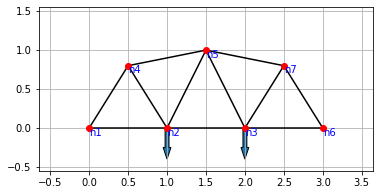

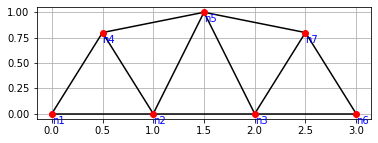

In [5]:
plotting(nodes,elemcon,1,0,1)
plotting(nodes,elemcon,1,0,0)

In [6]:
C=centroids(nodes,elemcon)
#print(C)

In [7]:
#Construct Element Stiffness Matrices:
KGlobal=np.zeros((len(nodes)*2,len(nodes)*2), dtype=float)

for x in range(len(elemdata)):
    #1) Stiffness Matrices in Element Coordinate System:
    #k=1 #for easier troubleshooting
    k=elemdata[x,0]*elemdata[x,1]/elemdata[x,2] #k=EA/L
    KLocal=np.array([[k,0,-k,0],
                     [0,0,0,0],
                     [-k,0,k,0],
                     [0,0,0,0]])

    #2) Element orientations in Global Coordinate System:
    Theta=np.arctan2((nodes[elemcon[x,1]-1,1]-nodes[elemcon[x,0]-1,1]),(nodes[elemcon[x,1]-1,0]-nodes[elemcon[x,0]-1,0]))
    T=np.array([[np.cos(Theta),-np.sin(Theta),0,0],
                [np.sin(Theta), np.cos(Theta),0,0],
                [0,0,np.cos(Theta),-np.sin(Theta)],
                [0,0,np.sin(Theta), np.cos(Theta)]])
    
    #3) Stiffness Matrices in Global Coordinate System:
    Nodes=np.array([(elemcon[x,0]),(elemcon[x,1])])
    DOF=np.array([[0,2*(Nodes[0]-1)+0],
                  [1,2*(Nodes[0]-1)+1],
                  [2,2*(Nodes[1]-1)+0],
                  [3,2*(Nodes[1]-1)+1]])
    
    KElGlobal=np.matmul(T,np.matmul(KLocal,np.linalg.inv(T)))
    
    #4) Assemble Element Stiffness Matrices:
    for i in range(4):
        for j in range(4):
            KGlobal[DOF[j,1],DOF[i,1]]+=KElGlobal[DOF[j,0],DOF[i,0]]
    
    del(DOF,KElGlobal,k,KLocal,Nodes,T,Theta) #Tidying

In [8]:
#Create BCs cutting matrix:
BCs=np.identity(len(nodes)*2)
FixedDoFs=np.zeros(len(nodes)*2) #Create a binary vector with 1s where DoFs are fixed
FixedDoFs[2*(XBCs[:]-1)]=1 #enter fixed x DoFs
FixedDoFs[2*(YBCs[:]-1)+1]=1 #enter fixed y DoFs

#Create Loads list:
LoadsList=np.reshape(Loads,[len(nodes)*2,1])

#Work backwards through the elements, removing columns
#Backwards counting for loop is required to manage the numbering:
for x in range(len(nodes)*2-1, -1, -1):
    if FixedDoFs[x]==1:          #if BC is fixed
        BCs=np.delete(BCs, x, 1) #remove column

#Reduce the Stiffness Matrix by removing fixed DoFs:
KGlobalReduced=np.matmul(np.transpose(BCs),KGlobal) #Removes Rows
KGlobalReduced=np.matmul(KGlobalReduced,BCs) #Removes Columns

#Reduce the Loads List
LoadsListReduced=np.matmul(np.transpose(BCs),LoadsList) #Removes Rows

#Invert Stiffness Matrix and Solve for Displacements:
DisplacementsReduced=np.matmul(np.linalg.inv(KGlobalReduced),LoadsListReduced)
#print(DisplacementsReduced)

#Reintroduce the zero displacements at fixed DoFs:
Displacements=np.matmul(BCs,DisplacementsReduced)

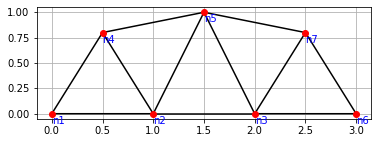

8.751950597137816e-05


In [9]:
#Calculate the new node locations for plotting
nodesdisp = nodes + np.reshape(Displacements,[len(nodes),2])
plotting(nodesdisp,elemcon,1,0)
a=np.max((abs(Displacements)))
print(a)

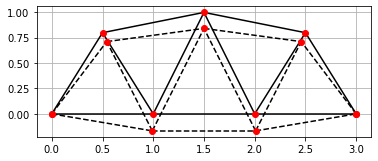

In [10]:
plotting(nodes,elemcon,0,0,0,1,0.15)

In [11]:
#Calculate Stresses:
Felem=np.zeros(len(elemcon))
Selem=np.zeros(len(elemcon))

for x in range(len(elemdata)):
    #1) Stiffness Matrices in Element Coordinate System:
    #k=1 #for easier troubleshooting
    k=elemdata[x,0]*elemdata[x,1]/elemdata[x,2] #k=EA/L
    KLocal=np.array([[k,0,-k,0],
                     [0,0,0,0],
                     [-k,0,k,0],
                     [0,0,0,0]])
    
    #2) Element orientations in Global Coordinate System:
    Theta=np.arctan2((nodes[elemcon[x,1]-1,1]-nodes[elemcon[x,0]-1,1]),(nodes[elemcon[x,1]-1,0]-nodes[elemcon[x,0]-1,0]))
    T=np.array([[np.cos(Theta),-np.sin(Theta),0,0],
                [np.sin(Theta), np.cos(Theta),0,0],
                [0,0,np.cos(Theta),-np.sin(Theta)],
                [0,0,np.sin(Theta), np.cos(Theta)]])
    
    #3) Stiffness Matrices in Global Coordinate System:
    Nodes=np.array([(elemcon[x,0]),(elemcon[x,1])])
    DOF=np.array([[0,2*(Nodes[0]-1)+0],
                  [1,2*(Nodes[0]-1)+1],
                  [2,2*(Nodes[1]-1)+0],
                  [3,2*(Nodes[1]-1)+1]])
    
    #3) Get global displacement vector for the element:
    Uelem=np.zeros([4,1])
    Uelem[:]=Displacements[DOF[:,1]]

    #then local displacement vector for the element
    uelem=np.zeros([4,1])
    uelem=np.matmul(np.linalg.inv(T),Uelem)
    
    #then elemental forces, and finally
    felem=np.zeros([4,1])
    felem[:]=np.matmul(KLocal,uelem)
    Felem[x]=felem[2]
    
    #elemental stresses
    Selem[x]=felem[2]/elemdata[x,0] #force corresponding with x DoF of second node
    
    del(DOF,felem,uelem,Uelem,Nodes,T,Theta) #Tidying

Selem[:]/=1000000 #Convert to MPa
#print(Selem)

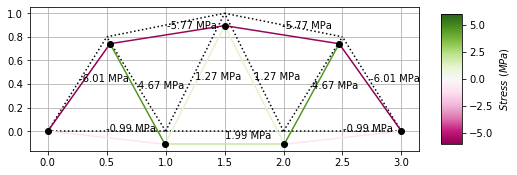

In [12]:
#Deformed, stressed plot with undeformed model for context:
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib as mpl

#Define stress colour contours
cmap=pl.cm.PiYG#PRGn
##Scale from min to max,
#cNorm=colors.Normalize(vmin=np.min(Selem[:]), vmax=np.max(Selem[:]))
#scalarMap=cmx.ScalarMappable(norm=cNorm,cmap=cmap)
#or Scale from -max to max or min to -min
max=np.max([np.abs(np.max(Selem[:])), np.abs(np.min(Selem[:]))])
cNorm=colors.Normalize(-max, max)
scalarMap=cmx.ScalarMappable(norm=cNorm,cmap=cmap)

#Plot the Mesh
fig=pl.figure()
ax=fig.add_axes([0.1, 0.1, 0.9, 0.55]) # [left, bottom, width, height]
axc=fig.add_axes([1.05, 0.15, 0.05, 0.45])

#Displacement may be too small to show, so we can #scale maximum displacements
#to dscale*longest element for display, where dscale is a scale factor
dscale=0.1
MaxDisp=np.max(elemdata[:,2])
DisplacementsPlot=Displacements/np.amax(abs(Displacements))*MaxDisp*dscale
nodesdisp=nodes+np.reshape(DisplacementsPlot,[len(nodes),2])
                
#Plot nodes
ax.plot(nodesdisp[:, 0], nodesdisp[:, 1], 'ko', zorder=3)
#Plot elements one by one. Note, node numbers have '-1' as numbered from 1, vs. python numbered from 0.
ax.plot([nodes[elemcon[:,0]-1,0],nodes[elemcon[:,1]-1,0]],[nodes[elemcon[:,0]-1,1],nodes[elemcon[:,1]-1,1]],'k:', zorder=2)

#Plot elements one by one. Note, node numbers have '-1' as numbered from 1, vs. python numbered from 0.
for x in range(len(elemcon)):
    colorval=scalarMap.to_rgba(Selem[x])
    ax.plot([nodesdisp[elemcon[x,0]-1,0],nodesdisp[elemcon[x,1]-1,0]],[nodesdisp[elemcon[x,0]-1,1],nodesdisp[elemcon[x,1]-1,1]],color=colorval, zorder=2)
    ax.set_aspect(1)
    ax.grid(1)
    
    elemstress=str(round(Selem[x], 2))+' MPa'
    ax.text((((nodesdisp[elemcon[x,0]-1,0]+nodesdisp[elemcon[x,1]-1,0])/2)),(((nodesdisp[elemcon[x,0]-1,1]+nodesdisp[elemcon[x,1]-1,1])/2)+0.05),elemstress,color='k')

colorbar=mpl.colorbar.ColorbarBase(axc,cmap=cmap,norm=cNorm,orientation='vertical',label="$Stress\ (MPa)$")
pl.show()


In [13]:
#Calculate Reaction Solution to Check?